# Comparison of classification models
Written by W.-H. Shin\
Aug. 2 2025\
Modified from Pat Walter's example.\
In this tutorial, we will compare three ML models: XGBoost, Random Forest, and LightGBM.

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

!conda install pandas seaborn numpy scikit-learn scipy mlxtend
!pip install useful_rdkit_utils scikit_posthocs xgboost lightgbm

✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.5.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [2]:
import requests
import os

Define a function to download a text file from a url. We'll use this to download a couple of Python files that we need from GitHub.

In [3]:
def download_text_file(url):
    res = requests.get(url)
    filename = os.path.basename(url)
    with open(filename,"w") as ifs:
        ifs.write(res.text)

Download two Python files from GitHub

In [4]:
support_url_list = [
    "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/support_libs/bootstrap.py",
    "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/support_libs/delong_ci.py"
]
for url in support_url_list:
    download_text_file(url)

Modifying the script not to cause error

In [5]:
# Read the content of the file
with open("delong_ci.py", "r") as f:
    content = f.read()

# Replace np.float with float
modified_content = content.replace("np.float", "float")

# Write the modified content back to the file
with open("delong_ci.py", "w") as f:
    f.write(modified_content)

print("Modified delong_ci.py to replace np.float with float")

Modified delong_ci.py to replace np.float with float


## Setup

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from rdkit import Chem
from mlxtend.evaluate import mcnemar, mcnemar_table
from itertools import combinations
from delong_ci import calc_auc_ci
from mlxtend.evaluate import paired_ttest_5x2cv
from bootstrap import bootstrap_error_estimate
from scipy import stats
import scikit_posthocs as sp
import useful_rdkit_utils as uru
from tqdm.auto import tqdm
from rdkit.rdBase import BlockLogs

In [8]:
sns.set(rc={'figure.figsize': (7, 7)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.color_palette("Set3")
pd.set_option('display.precision', 2)
tqdm.pandas()

## Get input data and preparation

In [9]:
data_url = "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/data/chembl_herg_log_activity.csv"
df = pd.read_csv(data_url)
df.head()

,smiles,pIC50
0,Brc1cc(CCN2CCN(CCc3ccc4C(=O)OCc4c3)CC2)ccc1C#N,6.25
1,Brc1ccc(CNC(=O)C2N(CCc3ccccn3)C(=O)c4ccccc24)cc1,5.03
2,Brc1ccc(NC(=O)N2CCN(C[C@@H]3CCCN(C3)C4CC4)CC2)cc1,5.15
3,Brc1ccc(cc1)N(C2CCN(CC2)C3CCCC3)C(=O)NCc4ccccc4,6.75
4,Brc1ccc(cc1)N(C2CCN(CC2)C3CCCC3)C(=O)Nc4ccccc4,6.73


Plot the distribution

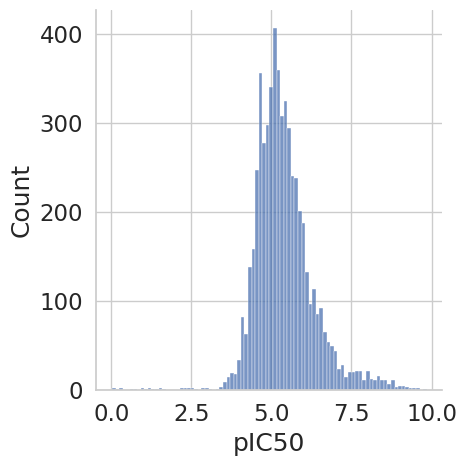

In [10]:
sns.displot(df.pIC50)

Assign labels for classification with a cutoff of IC50 < 1uM as active molecules

In [11]:
df['active'] = [int(x >= 6) for x in df.pIC50]
df.head()

,smiles,pIC50,active
0,Brc1cc(CCN2CCN(CCc3ccc4C(=O)OCc4c3)CC2)ccc1C#N,6.25,1
1,Brc1ccc(CNC(=O)C2N(CCc3ccccn3)C(=O)c4ccccc24)cc1,5.03,0
2,Brc1ccc(NC(=O)N2CCN(C[C@@H]3CCCN(C3)C4CC4)CC2)cc1,5.15,0
3,Brc1ccc(cc1)N(C2CCN(CC2)C3CCCC3)C(=O)NCc4ccccc4,6.75,1
4,Brc1ccc(cc1)N(C2CCN(CC2)C3CCCC3)C(=O)Nc4ccccc4,6.73,1


Calculate descriptors and fingerprints

In [12]:
block = BlockLogs()
df['mol'] = df.smiles.progress_apply(Chem.MolFromSmiles)
df['fp'] = df.mol.progress_apply(uru.mol2morgan_fp)
del block

  0%|          | 0/5691 [00:00<?, ?it/s]

  0%|          | 0/5691 [00:00<?, ?it/s]

## Generate models for classification
Generate three classification models: XGBooost, Random Forest, and LightGBM. \
10FCV for constructing model.

In [13]:
method_list = [XGBClassifier, RandomForestClassifier, LGBMClassifier]
method_name_list = [x().__class__.__name__ for x in method_list]
method_name_list = [x.replace("Classifier","") for x in method_name_list]
truth_list = []
pred_list = []
prob_list = []
cv_cycles = 10
for i in tqdm(range(0,cv_cycles)):
    train, test = train_test_split(df)
    train_X = np.stack(train.fp)
    train_y = train.active.values
    test_X = np.stack(test.fp)
    test_y = test.active.values
    cycle_pred = []
    cycle_prob = []
    for method in method_list:
        cls = method(n_jobs=-1)
        cls.fit(train_X,train_y)
        cycle_pred.append(cls.predict(test_X))
        cycle_prob.append(cls.predict_proba(test_X))

    truth_list.append(test.active.values)
    pred_list.append(cycle_pred)
    prob_list.append(cycle_prob)

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 885, number of negative: 3383
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3134
[LightGBM] [Info] Number of data points in the train set: 4268, number of used features: 1567
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207357 -> initscore=-1.340931
[LightGBM] [Info] Start training from score -1.340931


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 849, number of negative: 3419
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3132
[LightGBM] [Info] Number of data points in the train set: 4268, number of used features: 1566
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198922 -> initscore=-1.393044
[LightGBM] [Info] Start training from score -1.393044


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 872, number of negative: 3396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3128
[LightGBM] [Info] Number of data points in the train set: 4268, number of used features: 1564
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.204311 -> initscore=-1.359564
[LightGBM] [Info] Start training from score -1.359564


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 889, number of negative: 3379
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3124
[LightGBM] [Info] Number of data points in the train set: 4268, number of used features: 1562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208294 -> initscore=-1.335238
[LightGBM] [Info] Start training from score -1.335238


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 865, number of negative: 3403
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3138
[LightGBM] [Info] Number of data points in the train set: 4268, number of used features: 1569
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202671 -> initscore=-1.369683
[LightGBM] [Info] Start training from score -1.369683


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 883, number of negative: 3385
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3138
[LightGBM] [Info] Number of data points in the train set: 4268, number of used features: 1569
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206888 -> initscore=-1.343784
[LightGBM] [Info] Start training from score -1.343784


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 850, number of negative: 3418
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 4268, number of used features: 1558
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199157 -> initscore=-1.391575
[LightGBM] [Info] Start training from score -1.391575


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 879, number of negative: 3389
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3110
[LightGBM] [Info] Number of data points in the train set: 4268, number of used features: 1555
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.205951 -> initscore=-1.349505
[LightGBM] [Info] Start training from score -1.349505


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 860, number of negative: 3408
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3128
[LightGBM] [Info] Number of data points in the train set: 4268, number of used features: 1564
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201500 -> initscore=-1.376948
[LightGBM] [Info] Start training from score -1.376948


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 877, number of negative: 3391
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3158
[LightGBM] [Info] Number of data points in the train set: 4268, number of used features: 1579
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.205483 -> initscore=-1.352373
[LightGBM] [Info] Start training from score -1.352373


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Evaluate models
Calculating AUC

In [14]:
auc_result = []
for truth, prob in zip(truth_list,prob_list):
    for name, p in zip(method_name_list, prob):
        auc_result.append([name,roc_auc_score(truth,p[:,1])])
auc_df = pd.DataFrame(auc_result,columns=["Method","AUC"])

## Wrong ways for comparison
Barplots with whiskers

/tmp/ipython-input-4204898997.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Method",y="AUC",data=auc_df, palette="deep")
/tmp/ipython-input-4204898997.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=labels)


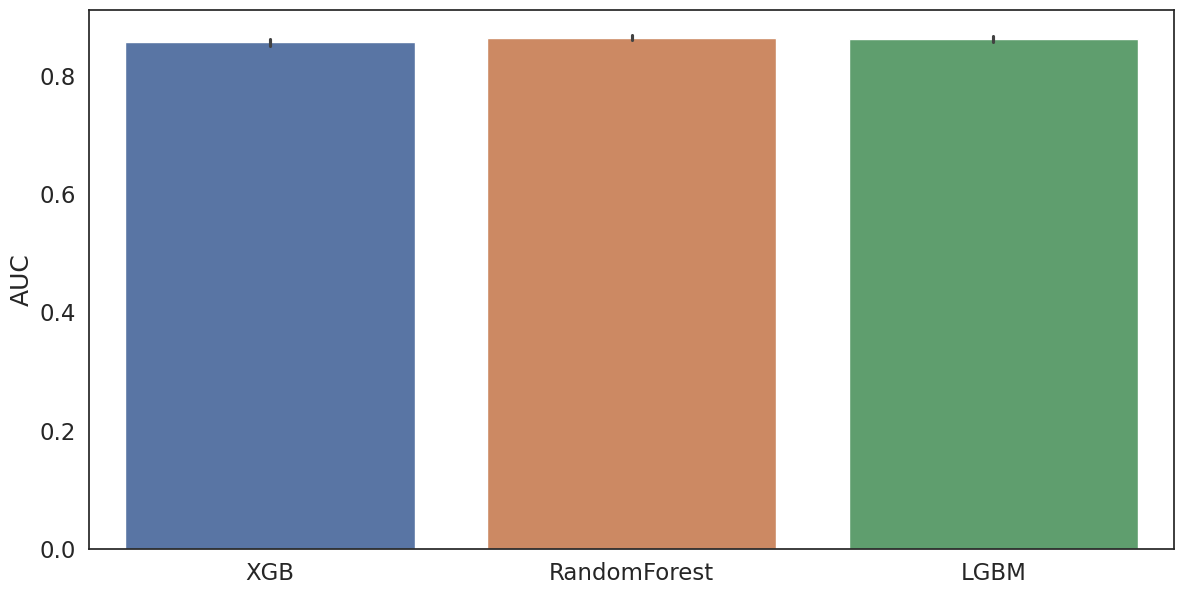

In [23]:
ax = sns.barplot(x="Method",y="AUC",data=auc_df, palette="deep")
labels = [x.get_text() for x in ax.get_xticklabels()]
ax.set(xticklabels=labels)
_ = ax.set(xlabel="")

Alternative way for showing AUC

/tmp/ipython-input-2361547648.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(y="Method",x="AUC",data=auc_df,notch=True, palette="deep")


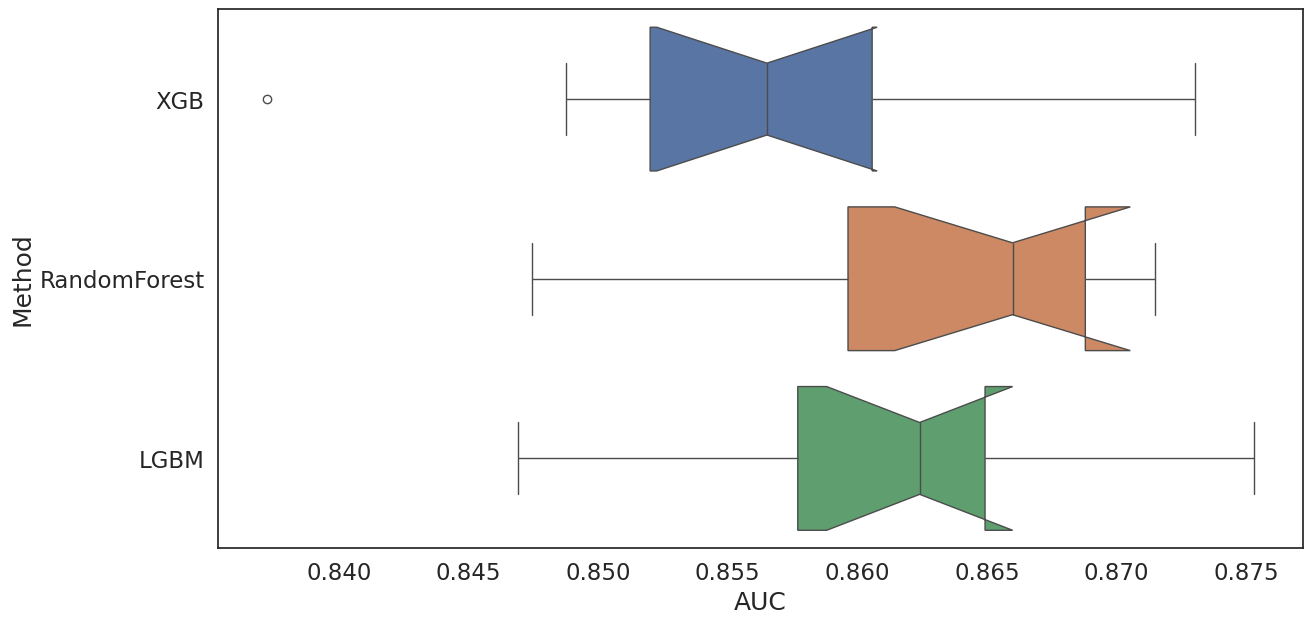

In [24]:
ax = sns.boxplot(y="Method",x="AUC",data=auc_df,notch=True, palette="deep")

## Confidence intervals for AUC

In [17]:
auc_result = []
for cycle, [truth, prob] in enumerate(zip(truth_list,prob_list)):
    for name, p in zip(method_name_list, prob):
        truth = np.array([int(x) for x in truth])
        auc, (lb, ub) = calc_auc_ci(truth,p[:,1])
        auc_result.append([cycle,name, auc, lb, ub])
auc_ci_df = pd.DataFrame(auc_result,columns=["Cycle","Method","AUC","LB","UB"])
auc_ci_df.head()

,Cycle,Method,AUC,LB,UB
0,0,XGB,0.85,0.83,0.88
1,0,RandomForest,0.86,0.84,0.89
2,0,LGBM,0.86,0.84,0.89
3,1,XGB,0.85,0.83,0.88
4,1,RandomForest,0.86,0.83,0.88


In [18]:
sns.set(rc={'figure.figsize': (14, 7)})
sns.set(font_scale=1.5)
sns.set_style('white')

Subroutine for plotting AUC with the confidence level

In [21]:
def ci_pointplot(input_df, x_col="Cycle", y_col="AUC", hue_col="Method", lb_col="LB", ub_col="UB"):
    dodge_val = 0.25
    palette_name = "deep"
    cv_cycles = len(input_df[x_col].unique())
    ax = sns.pointplot(x=x_col, y=y_col, hue=hue_col, data=input_df, dodge=dodge_val, join=False, palette=palette_name)
    ax.axvline(0.5, ls="--", c="gray")
    for x in np.arange(0.5, cv_cycles, 1):
        ax.axvline(x, ls="--", c="gray")
    y_val = input_df[y_col]
    lb = y_val - input_df[lb_col]
    ub = input_df[ub_col] - y_val
    x_pos = []
    cols = sns.color_palette(palette_name)[:3]
    for i in range(0, cv_cycles):
        x_pos += [i - dodge_val / 2, i, i + dodge_val / 2]
    _ = ax.errorbar(x_pos, y_val, yerr=[lb, ub], fmt="none", capsize=0,ecolor=cols)

/tmp/ipython-input-3190651643.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(x=x_col, y=y_col, hue=hue_col, data=input_df, dodge=dodge_val, join=False, palette=palette_name)


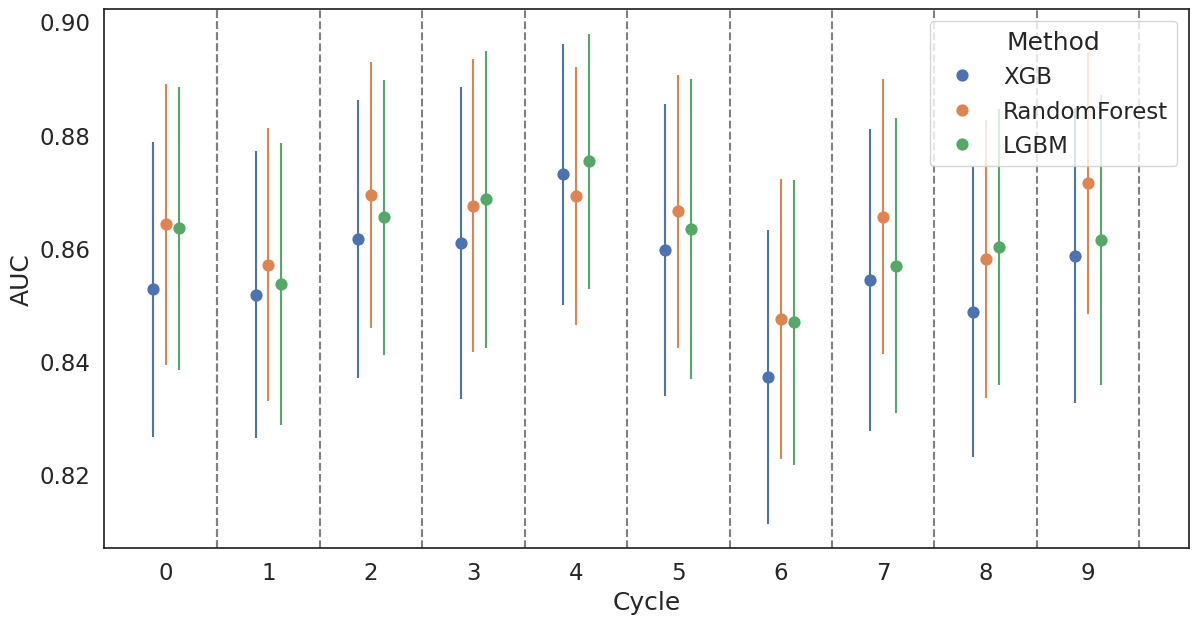

In [22]:
ci_pointplot(auc_ci_df)

## Bootstrap for estimating error

In [25]:
bootstrap_result = []
with tqdm(total=len(truth_list)) as pbar:
    for cycle,[truth,probs] in enumerate(zip(truth_list,prob_list)):
        for name,p in zip(method_name_list,probs):
            auc = roc_auc_score(truth,p[:,1])
            lb,ub = bootstrap_error_estimate(truth,p[:,1],roc_auc_score)
            bootstrap_result.append([cycle,name,auc,lb,ub])
        pbar.update(1)
bootstrap_df = pd.DataFrame(bootstrap_result,columns=["Cycle","Method","AUC","LB","UB"])

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipython-input-3190651643.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(x=x_col, y=y_col, hue=hue_col, data=input_df, dodge=dodge_val, join=False, palette=palette_name)


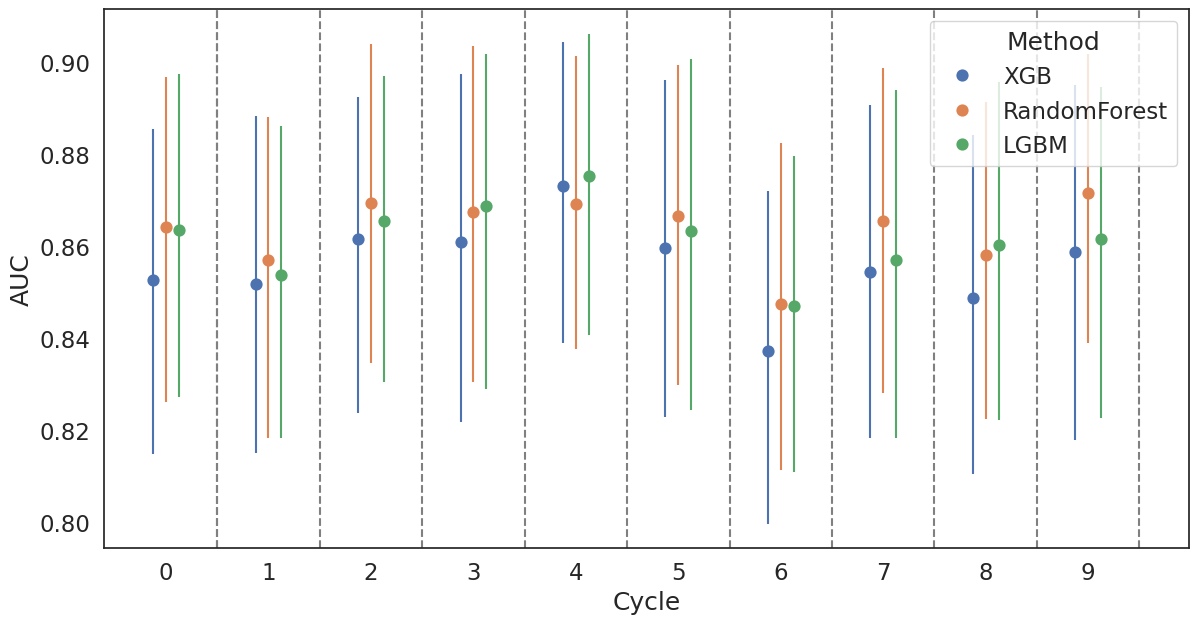

In [26]:
ci_pointplot(bootstrap_df)

## 5*2-CV

In [27]:
X = np.stack(df.fp)
y = df.active.values
classifier_list = [x(n_jobs=-1) for x in method_list]
print(f"{'Method_1':12s} {'Method_2':12s} {'p-value'}")
for a,b in combinations(zip(classifier_list,method_name_list),2):
    clf1,name1 = a
    clf2,name2 = b
    t, p = paired_ttest_5x2cv(estimator1=clf1,estimator2=clf2,X=X, y=y, scoring="roc_auc")
    print(f"{name1:12s} {name2:12s} {p:.3f}")

Method_1     Method_2     p-value
XGB          RandomForest 0.219
[LightGBM] [Info] Number of positive: 564, number of negative: 2281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2580
[LightGBM] [Info] Number of data points in the train set: 2845, number of used features: 1290
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198243 -> initscore=-1.397315
[LightGBM] [Info] Start training from score -1.397315


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 601, number of negative: 2245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2584
[LightGBM] [Info] Number of data points in the train set: 2846, number of used features: 1292
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211174 -> initscore=-1.317866
[LightGBM] [Info] Start training from score -1.317866


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 577, number of negative: 2268
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2600
[LightGBM] [Info] Number of data points in the train set: 2845, number of used features: 1300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202812 -> initscore=-1.368811
[LightGBM] [Info] Start training from score -1.368811


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 588, number of negative: 2258
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2568
[LightGBM] [Info] Number of data points in the train set: 2846, number of used features: 1284
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206606 -> initscore=-1.345508
[LightGBM] [Info] Start training from score -1.345508


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 618, number of negative: 2227
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2556
[LightGBM] [Info] Number of data points in the train set: 2845, number of used features: 1278
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217223 -> initscore=-1.281922
[LightGBM] [Info] Start training from score -1.281922


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 547, number of negative: 2299
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2610
[LightGBM] [Info] Number of data points in the train set: 2846, number of used features: 1305
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.192200 -> initscore=-1.435781
[LightGBM] [Info] Start training from score -1.435781


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 613, number of negative: 2232
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2574
[LightGBM] [Info] Number of data points in the train set: 2845, number of used features: 1287
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215466 -> initscore=-1.292288
[LightGBM] [Info] Start training from score -1.292288


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 552, number of negative: 2294
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2592
[LightGBM] [Info] Number of data points in the train set: 2846, number of used features: 1296
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193956 -> initscore=-1.424504
[LightGBM] [Info] Start training from score -1.424504


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 572, number of negative: 2273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2582
[LightGBM] [Info] Number of data points in the train set: 2845, number of used features: 1291
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201054 -> initscore=-1.379717
[LightGBM] [Info] Start training from score -1.379717


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 593, number of negative: 2253
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2586
[LightGBM] [Info] Number of data points in the train set: 2846, number of used features: 1293
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208363 -> initscore=-1.334824
[LightGBM] [Info] Start training from score -1.334824


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


XGB          LGBM         0.173
[LightGBM] [Info] Number of positive: 575, number of negative: 2270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2600
[LightGBM] [Info] Number of data points in the train set: 2845, number of used features: 1300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202109 -> initscore=-1.373165
[LightGBM] [Info] Start training from score -1.373165


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 590, number of negative: 2256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2600
[LightGBM] [Info] Number of data points in the train set: 2846, number of used features: 1300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207309 -> initscore=-1.341226
[LightGBM] [Info] Start training from score -1.341226


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 604, number of negative: 2241
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2582
[LightGBM] [Info] Number of data points in the train set: 2845, number of used features: 1291
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212302 -> initscore=-1.311103
[LightGBM] [Info] Start training from score -1.311103


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 561, number of negative: 2285
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2600
[LightGBM] [Info] Number of data points in the train set: 2846, number of used features: 1300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197119 -> initscore=-1.404400
[LightGBM] [Info] Start training from score -1.404400


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 589, number of negative: 2256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2584
[LightGBM] [Info] Number of data points in the train set: 2845, number of used features: 1292
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207030 -> initscore=-1.342922
[LightGBM] [Info] Start training from score -1.342922


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 576, number of negative: 2270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2582
[LightGBM] [Info] Number of data points in the train set: 2846, number of used features: 1291
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202389 -> initscore=-1.371427
[LightGBM] [Info] Start training from score -1.371427


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 585, number of negative: 2260
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2576
[LightGBM] [Info] Number of data points in the train set: 2845, number of used features: 1288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.205624 -> initscore=-1.351508
[LightGBM] [Info] Start training from score -1.351508


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 580, number of negative: 2266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2600
[LightGBM] [Info] Number of data points in the train set: 2846, number of used features: 1300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203795 -> initscore=-1.362743
[LightGBM] [Info] Start training from score -1.362743


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 565, number of negative: 2280
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2586
[LightGBM] [Info] Number of data points in the train set: 2845, number of used features: 1293
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198594 -> initscore=-1.395105
[LightGBM] [Info] Start training from score -1.395105


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 600, number of negative: 2246
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.164724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 2846, number of used features: 1310
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210822 -> initscore=-1.319976
[LightGBM] [Info] Start training from score -1.319976
RandomForest LGBM         0.025


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## McNemar's test


In [28]:
mc_result = []
for truth, pred in zip(truth_list,pred_list):
    for i,j in combinations(range(len(method_list)),2):
        mc, mc_pvalue = mcnemar(mcnemar_table(truth, pred[i], pred[j]))
        mc_result.append([method_name_list[i],method_name_list[j], mc_pvalue])
mc_df = pd.DataFrame(mc_result,columns=["Method_1","Method_2","p_value"])
mc_df['Combo'] = mc_df.Method_1 + "_" + mc_df.Method_2
mc_df.head()

,Method_1,Method_2,p_value,Combo
0,XGB,RandomForest,0.39,XGB_RandomForest
1,XGB,LGBM,0.79,XGB_LGBM
2,RandomForest,LGBM,0.23,RandomForest_LGBM
3,XGB,RandomForest,0.71,XGB_RandomForest
4,XGB,LGBM,0.35,XGB_LGBM


## Account for multiple testing
Bonferroni's correction

In [29]:
alpha = 0.05/len(pred_list[0])
alpha

0.016666666666666666

/tmp/ipython-input-893303561.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="p_value",y="Combo",data=mc_df, palette="deep")


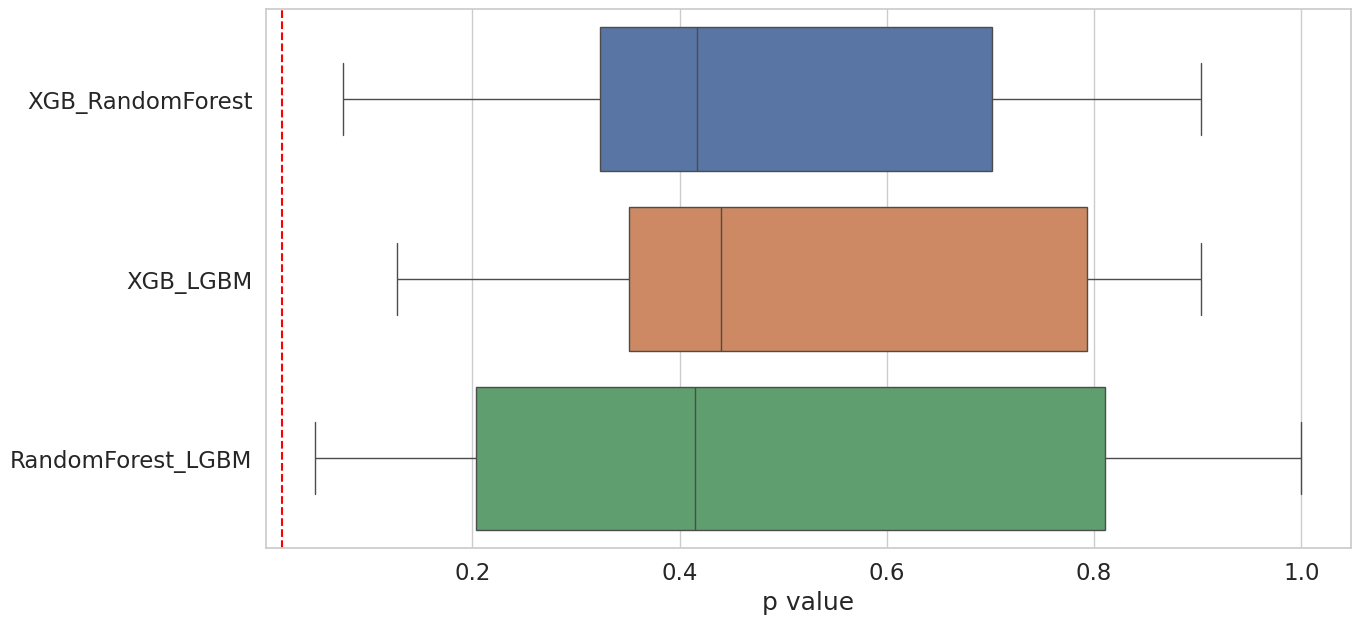

In [31]:
sns.set(rc={'figure.figsize': (14, 7)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
ax = sns.boxplot(x="p_value",y="Combo",data=mc_df, palette="deep")
ax.set(ylabel="",xlabel="p value")
_ = ax.axvline(alpha,c="red",ls="--")

## Friedman's Test with Mann-Whitney Post-hoc

In [40]:
auc_dict = {}
for k,v in auc_ci_df.groupby("Method"):
    auc_dict[k] = v.AUC
statistic = stats.friedmanchisquare(*auc_dict.values())
print('statistic:', float(statistic[0]))
print('p-value', float(statistic[1]))

statistic: 12.599999999999994
p-value 0.001836304777028912


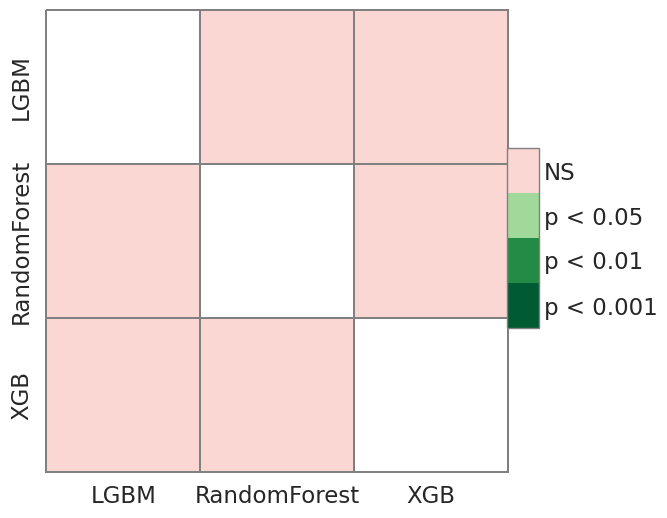

In [35]:
sns.set(rc={'figure.figsize':(8,6)},font_scale=1.5)
pc = sp.posthoc_mannwhitney(auc_ci_df,val_col="AUC",group_col="Method",p_adjust='holm')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
_ = sp.sign_plot(pc, **heatmap_args)